In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [48]:
info = get_info(sfreq=100, kind="biosemi64")
fwd = create_forward_model(sampling="ico3", info=info)
leadfield = fwd["sol"]["data"]
pos_left = fwd["src"][0]["rr"][fwd["src"][0]["vertno"], :]
pos_right = fwd["src"][1]["rr"][fwd["src"][1]["vertno"], :]
pos = np.concatenate((pos_left, pos_right), axis=0)
n_chans, n_dipoles = leadfield.shape

import mne
from scipy.sparse.csgraph import laplacian

adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
laplace_operator = abs(laplacian(adjacency))
# laplace_operator = laplace_operator @ laplace_operator
# laplace_operator = np.identity(n_dipoles)

-- number of adjacent vertices : 1284


# Models

## The Generator

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Input, Lambda, LayerNormalization
from tensorflow.keras.layers import Activation, Dropout, ActivityRegularization, TimeDistributed
from tensorflow.keras.layers import Reshape, Permute, GaussianNoise, add, BatchNormalization, multiply
from esinet.losses import chamfer2
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
# import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l1, l2, l1_l2

def weightedLoss(w):
    def loss(true, pred):
        print("DISC", true, pred)
        
        error = K.square(true - pred)
        # error = K.abs(true - pred)
        error = K.switch(K.equal(true, 0), w * error , error)
        # normalize for number of active sites
        error = error / tf.linalg.norm(true, axis=-1)
        return error
    return loss

def weightedLossGan(w):
    def loss(true, pred):
        print("GAN", true, pred)
        error = K.square(true - pred)
        # error = K.abs(true - pred)
        error = K.switch(K.equal(true, 0), w * error , error)
        # normalize for number of active sites
        error = error * tf.linalg.norm(true)
        return -error
    return loss


def custom_gan_loss(y_ones, y_both):
    y_true = y_both[0]
    y_pred = y_both[1]
    # print(y_ones, y_true, y_pred)
    
    error = -tf.keras.losses.CosineSimilarity()(y_true, y_pred)
    # error = -tf.keras.losses.mean_squared_error(y_true, y_pred)
    # blur =  tf.cast(tf.size(y_true), dtype=tf.float32) / tf.math.count_nonzero(y_true, dtype=tf.float32)
    # blur = K.mean(K.abs(y_true))
    # error = K.square(y_true -y_pred)
    # error = error / tf.linalg.norm(y_true, axis=-1)
    # error = -K.mean(error)
    # normalize for number of active sites
    # error = error / tf.linalg.norm(y_true)
    # norm = tf.linalg.norm(y_true)

    # Maximize variance of norms
    # norm_variance = 1/tf.math.reduce_std(tf.linalg.norm(y_true, axis=-1))

    return error #+ norm

def square(x):
    return K.square(x) * K.sign(x)
    
def scale_act(x):
    return tf.transpose(tf.transpose(x) / tf.math.reduce_max(K.abs(x), axis=-1))
        

class CustomDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training: #you can remove this line,, so that you can use dropout on inference time
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

def wasserstein_loss(y_true, y_pred):
	return K.mean(y_true * y_pred)

def wasserstein_loss_inv(y_true, y_pred):
	return - K.mean(y_true * y_pred)

class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return K.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

def define_gan(g_model, d_model, latent_dim, learning_rate=0.0001):
    n_chans, n_dipoles = leadfield.shape
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    d_model.trainable = False
    inputs = tf.keras.Input(shape=(latent_dim), name='Input_Generator')
    output_1 = g_model(inputs)
    eeg = Lambda(lambda x: tf.transpose(tf.linalg.matmul(leadfield_, tf.transpose(x))), output_shape=(None, n_chans))(output_1)
    
    # print("eeg from source from g: ", eeg)
    eeg_normed = LayerNormalization()(eeg)
    
    # print("eeg_normed from source from g: ", eeg_normed)
    output_3 = d_model(eeg_normed)
    model = Model(inputs, [output_1, output_3])

    # Add loss to model
    loss = K.abs(tf.keras.losses.CosineSimilarity()(output_1, output_3)) #+ l1_sparsity(output_1)
    model.add_loss(loss)

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
    return model


def define_discriminator(n_dense_layers=2, hidden_units=200, learning_rate=0.0001):
    input_shape = (n_chans)
    inputs = tf.keras.Input(shape=input_shape, name='Input_Discriminator')
    activation = "tanh"
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)

    # fc = Dense(hidden_units, activation=activation, name="HL_D1")(inputs)
    # for i in range(n_dense_layers-1):
    #     fc = Dense(hidden_units, activation=activation, name=f"HL_D{i+2}")(fc)
    # out = Dense(n_dipoles, activation="linear", name="Output_Final")(fc)

    fc1 = Dense(hidden_units, activation=activation, name="HL_D1")(inputs)
    fc2 = Dense(hidden_units, activation=activation, name="HL_D2")(fc1)
    adder = add([fc1, fc2])

    fc3 = Dense(hidden_units, activation=activation, name="HL_D3")(adder)
    fc4 = Dense(hidden_units, activation=activation, name="HL_D4")(fc3)
    adder = add([fc3, fc4])
    out = Dense(n_dipoles, activation="linear", name="Output_Final")(adder)
    
    model = tf.keras.Model(inputs=inputs, outputs=out, name='Discriminator')
    model.add_loss(l1_sparsity(out))
    # model.add_loss( tf.keras.losses.CosineSimilarity(name="meas_loss")(tf.linalg.matmul(leadfield_, tf.transpose(out)),  tf.transpose(inputs)) )

    model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    # model.compile(loss=chamfer2(pos), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
    return model
  
def define_discriminator2(n_dense_layers=2, hidden_units=200, learning_rate=0.0001):
    input_shape = (n_chans)
    inputs = tf.keras.Input(shape=input_shape, name='Input_Discriminator')
    activation = "tanh"
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    inverse_operator = tf.linalg.pinv(leadfield_)
    minimum_norm = Lambda(lambda x: tf.transpose(tf.linalg.matmul(inverse_operator, tf.transpose(x))), output_shape=(None, n_dipoles))(inputs)
    minimum_norm = Activation(scale_act)(minimum_norm)
    
    fc1 = Dense(hidden_units, activation=activation, name="HL_D1")(minimum_norm)
    fc2 = Dense(hidden_units, activation=activation, name="HL_D2")(fc1)
    adder = add([fc1, fc2])

    fc3 = Dense(hidden_units, activation=activation, name="HL_D3")(adder)
    fc4 = Dense(hidden_units, activation=activation, name="HL_D4")(fc3)
    adder = add([fc3, fc4])
    out = Dense(n_dipoles, activation="linear", name="Output_Final")(adder)
    out = multiply([out, minimum_norm])
    
    model = tf.keras.Model(inputs=inputs, outputs=out, name='Discriminator')
    # model.add_loss(l1_sparsity(out))
    # model.add_loss( tf.keras.losses.CosineSimilarity(name="meas_loss")(tf.linalg.matmul(leadfield_, tf.transpose(out)),  tf.transpose(inputs)) )

    model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

def define_generator(latent_dim=100, sparsity=1):
    laplace_operator_ = tf.cast(laplace_operator, dtype=tf.float32)

    lrelu = tf.keras.layers.LeakyReLU()
    inputs = tf.keras.Input(shape=(latent_dim), name='Input_Generator')
    fc = Dense(latent_dim, activation=lrelu, name="HL_G1")(inputs)
    gen_out_sparse = Dense(n_dipoles, name="Output_Generator", activation="tanh")(fc)
    
    fc = Dense(100, activation=lrelu, name="HL_D1")(inputs)
    
    # fc2 = Dense(hidden_units, activation=lrelu, name="HL_D2")(fc1)
    # adder = add([fc1, fc2])

    # fc3 = Dense(hidden_units, activation=lrelu, name="HL_D3")(adder)
    # fc4 = Dense(hidden_units, activation=lrelu, name="HL_D4")(fc3)
    # adder = add([fc3, fc4])
    # gen_out_sparse = Dense(n_dipoles, name="Output_Generator", activation="tanh")(adder)

    gen_out = Lambda(lambda x: tf.transpose(tf.linalg.matmul(laplace_operator_, tf.transpose(x))), output_shape=(None, n_chans))(gen_out_sparse)
    model = tf.keras.Model(inputs=inputs, outputs=gen_out, name='Generator')
    model.add_loss(l1_sparsity( gen_out_sparse )*sparsity)

    return model


def l1_sparsity(x):
    return K.mean(K.abs(x)) 

def batch_diversity(x):
    diversity = K.std(K.mean(K.abs(x), axis=0))
    return diversity

def prep_data(X, y):
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)
    return X, y
    
def prep_data_sim(sim):
    X = np.squeeze(np.stack([eeg.average().data for eeg in sim.eeg_data]))
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.squeeze(np.stack([src.data for src in sim.source_data]))
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)

    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=-1)
        y = np.expand_dims(y, axis=-1)
    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    return X, y

def generate_samples(g_model, batch_size, latent_dim):
    x_input = np.random.randn(batch_size, latent_dim)
    sources = g_model.predict(x_input)
    return sources

def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.

    This is a fast approximation of re-initializing the weights of a model.

    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).

    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)
    return model

n_epochs = 200
batch_size = 32
batch_number = 10
latent_dim = 16
# define_discriminator2()
# g, d, gan = define_models(latent_dim, hidden_units=latent_dim)
# gan(np.random.randn(batch_size, latent_dim))

# Simulate

In [4]:
settings = dict(duration_of_trial=0.01, extents=(1, 40), number_of_sources=(1,15), target_snr=1e99)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=100)
X_test = np.stack([eeg.average().data[:, 0] for eeg in sim.eeg_data], axis=0)
y_test = np.stack([source.data[:, 0] for source in sim.source_data], axis=0)
X_test, y_test = prep_data(X_test, y_test)

Simulating data based on sparse patches.


100%|██████████| 100/100 [00:00<00:00, 656.77it/s]


# Train

In [68]:
from tqdm.notebook import tqdm
n_chans, n_dipoles = leadfield.shape
n_epochs = 10000
batch_size = 32
latent_dim = 10
hidden_units = 400
disc_mod = 1
gen_mod = 1
reps = 5
learning_rate = 0.001
sparsity = 100
# g_model, d_model, gan_model = define_models(latent_dim, hidden_units=hidden_units, reg=reg, learning_rate=0.01)

d_model = define_discriminator(learning_rate=learning_rate, hidden_units=hidden_units)
g_model = define_generator(latent_dim=latent_dim, sparsity=sparsity)
gan_model = define_gan(g_model, d_model, latent_dim, learning_rate=learning_rate)

X_history = np.zeros((0, n_chans))
y_history = np.zeros((0, n_dipoles))
gan_losses = np.zeros(n_epochs)
d_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
generated = []

for i in tqdm(range(n_epochs)):
    if i % disc_mod == 0:
        print("Train Discriminator")
        y = generate_samples(g_model, batch_size, latent_dim)
        X = (leadfield @ y.T).T
        X, _ = prep_data(X,y)
        generated.append(abs(y).mean(axis=0))
        X_history = np.append(X_history, X, axis=0)
        y_history = np.append(y_history, y, axis=0)
        idc = np.arange(X_history.shape[0])
        np.random.shuffle(idc)
        X_history = X_history[idc]
        y_history = y_history[idc]
        X_history = X_history[:batch_size]
        y_history = y_history[:batch_size]
        for _ in range(1):
            d_loss = d_model.train_on_batch(X_history, y_history)
        
        # d_loss = d_model.train_on_batch(X, y)
        d_model.trainable = True
        # test_loss = d_model.evaluate(X_test, y_test, verbose=0)
        test_loss = tf.keras.losses.CosineSimilarity()(tf.cast(y_test, dtype=tf.float32), tf.cast(d_model.predict(X_test), dtype=tf.float32)).numpy()
        test_losses[i] = test_loss

        # print(f"disc_loss befoer: {d_loss}")
    # if d_loss < -0.3:

    if i % gen_mod == 0:# and d_loss<-0.15:
        g_model = define_generator(latent_dim=latent_dim, sparsity=sparsity)
        gan_model.layers[1] = g_model
        print("Train Generator")
        x_input = np.random.randn(batch_size, latent_dim)

        X = np.ones((batch_size, n_dipoles))
        d_model.trainable = False
        gan_model.layers[4].trainable = False
        for _ in range(15):
            gan_loss = gan_model.train_on_batch(x_input, X)
        d_model.trainable = True
        gan_model.layers[4].trainable = True
      
    print(f'test_loss: {test_loss:.2f}, disc-loss: {d_loss:.2f}, gan-loss: {gan_loss:.2f}')
    d_losses[i] = d_loss
    
    gan_losses[i] = gan_loss

  0%|          | 0/10000 [00:00<?, ?it/s]

Train Discriminator
Train Generator
test_loss: -0.00, disc-loss: 0.31, gan-loss: 4.27
Train Discriminator
Train Generator
test_loss: -0.01, disc-loss: 0.16, gan-loss: 2.74
Train Discriminator
Train Generator
test_loss: -0.01, disc-loss: 0.12, gan-loss: 2.08
Train Discriminator
Train Generator
test_loss: -0.01, disc-loss: 0.13, gan-loss: 1.26
Train Discriminator
Train Generator
test_loss: -0.02, disc-loss: 0.13, gan-loss: 0.90
Train Discriminator
Train Generator
test_loss: -0.02, disc-loss: 0.18, gan-loss: 0.78
Train Discriminator
Train Generator
test_loss: -0.02, disc-loss: 0.16, gan-loss: 0.63
Train Discriminator
Train Generator
test_loss: -0.02, disc-loss: 0.18, gan-loss: 0.67
Train Discriminator
Train Generator
test_loss: -0.02, disc-loss: 0.16, gan-loss: 0.56
Train Discriminator
Train Generator
test_loss: -0.02, disc-loss: 0.15, gan-loss: 0.48
Train Discriminator
Train Generator
test_loss: -0.02, disc-loss: 0.17, gan-loss: 0.46
Train Discriminator
Train Generator
test_loss: -0.02, 

KeyboardInterrupt: 

# Tests

MSE:  1.8377213 Cos:  tf.Tensor(-0.17601246, shape=(), dtype=float32)
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


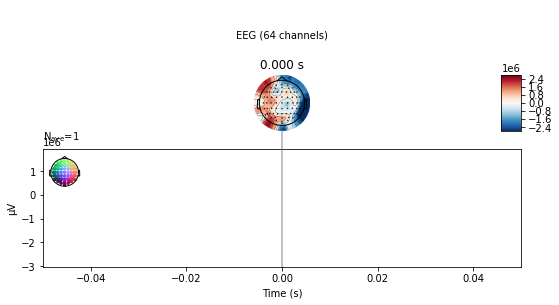

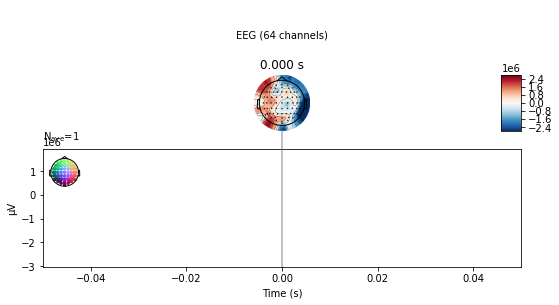

In [46]:
stc_ = sim.source_data[0].copy()
noise = np.random.randn(1, latent_dim)
src = g_model(noise).numpy().T
eeg = leadfield @ src
eeg -= eeg.mean()
eeg /= eeg.std()
src_hat = d_model(eeg[np.newaxis]).numpy().T

print("MSE: ", np.mean((src-src_hat)**2), "Cos: ", tf.keras.losses.CosineSimilarity()(src, src_hat))


stc_.data = src
stc_.plot(**plot_params)

stc_.data = src_hat
stc_.plot(**plot_params)

evoked = mne.EvokedArray(eeg, info)
evoked.plot_joint()

In [24]:
stc = sim.source_data[0].copy()
stc_ = stc.copy()
stc_.data = np.stack(generated, axis=0).T
stc_.plot(**plot_params)

In [65]:
%matplotlib qt
plt.figure()
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(gan_losses, label="GAN Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()

# # g_model, d_model, gan_model = define_models(latent_dim, hidden_units=hidden_units, reg=reg)

y = generate_samples(g_model, 1000, latent_dim)
data = abs(y).mean(axis=0)
stc_ = stc.copy()
stc_.data[:, 0] = data
stc_.plot(**plot_params)

stc_.data = y.T
stc_.plot(**plot_params)

plt.figure()
plt.hist(y.flatten())
print("Batch Diversity: ", batch_diversity(y).numpy(), "L1: ", l1_sparsity(y).numpy())

Batch Diversity:  0.100420564 L1:  0.4168608


# Evaluate

## Simulation

In [69]:
n_samples = 2
# settings = dict(duration_of_trial=0.1, extents=(1,40), number_of_sources=(1,15), target_snr=1e99, source_number_weighting=False)
# settings = dict(duration_of_trial=0.1, extents=(1,25), number_of_sources=15, target_snr=1e99)
settings = dict(duration_of_trial=0.01, extents=25, number_of_sources=1, target_snr=1e99)

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

X = np.stack([eeg.average().data for eeg in sim_test.eeg_data], axis=0)
y = np.stack([src.data for src in sim_test.source_data], axis=0)

X, y = prep_data(X[0].T, y[0].T)

y_hat = d_model.predict(X)
y_hat.shape
stc = sim_test.source_data[0]
stc.data /= np.max(abs(stc.data))
stc.plot(**plot_params, brain_kwargs=dict(title="Ground Truth Sim"), clim=dict(kind='percent', pos_lims=(0, 50, 100)))

stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title="GAN"))
from scipy.stats import pearsonr
from esinet.evaluate import eval_auc
_, pos = util.unpack_fwd(fwd)[1:3]
auc = np.mean([np.mean(eval_auc(y_true, y_pred, pos)) for y_true, y_pred in zip(stc.data.T, stc_hat.data.T)])
cosine = tf.keras.losses.CosineSimilarity()(tf.cast(stc.data.T, dtype=tf.float32), tf.cast(stc_hat.data.T, dtype=tf.float32)).numpy()
r,p = pearsonr(stc.data.flatten(), stc_hat.data.flatten())
print(f'auc={auc:.2f}, cosine={cosine}, r={r:.2f}, p={p:.4f}\n')

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 400.09it/s]


auc=0.80, cosine=-0.24229243397712708, r=0.24, p=0.0000



In [48]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping, SolverMinimumNorm
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

# solver = SolverLAURA().make_inverse_operator(fwd)
# solver = SolverChampagne().make_inverse_operator(fwd)
solver = SolverMinimumNorm().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(sim_test.eeg_data[0].average())
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
r,p = pearsonr(stc.data.flatten(), stc_mne.data.flatten())
auc = np.mean([np.mean(eval_auc(y_true, y_pred, pos)) for y_true, y_pred in zip(stc.data.T, stc_mne.data.T)])
cosine = tf.keras.losses.CosineSimilarity()(tf.cast(stc.data.T, dtype=tf.float32), tf.cast(stc_mne.data.T, dtype=tf.float32)).numpy()

print(f'auc={auc:.2f}, cosine={cosine}, r={r:.2f}, p={p:.4f}\n')

auc=0.89, cosine=-0.4212958812713623, r=0.43, p=0.0000



# Test Discriminator with Generator

In [52]:
# generated data:
y = generate_samples(g_model, 32, latent_dim)
X = (leadfield @ y.T).T
X, y = prep_data(X,y)

y[np.isnan(y)] = 0
stc_hat.data = y.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Ground Truth"), clim=dict(kind='value', pos_lims=(0, 0.5, 1)))

y_hat = d_model.predict(X)
y_hat[np.isnan(y_hat)] = 0

stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title="GAN"), clim=dict(kind='value', pos_lims=(0, 0.5, 1)))

r,p = pearsonr(y.flatten(), y_hat.flatten())
auc = np.mean([np.mean(eval_auc(yy_true, yy_pred, pos)) for yy_true, yy_pred in zip(y, y_hat)])

print(f'auc={auc:.2f}, r={r:.2f}, p={p:.4f}\n')

auc=0.91, r=0.84, p=0.0000



# Linear Solution

In [53]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

evoked = mne.EvokedArray(X.T, info)

# solver = SolverLAURA().make_inverse_operator(fwd)
# solver = SolverChampagne().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(evoked)
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
r,p = pearsonr(y.flatten(), stc_mne.data.flatten())
auc = np.mean([np.mean(eval_auc(yy_true, yy_pred, pos)) for yy_true, yy_pred in zip(y, stc_mne.data.T)])

print(f'auc={auc:.2f}, r={r:.2f}, p={p:.4f}\n')

auc=0.51, r=-0.01, p=0.0427



Using control points [0.02927872 0.03322611 0.06774781]
Using control points [0.42319688 0.4607384  0.93013235]


## old functions

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Input, Lambda
import numpy as np


basic_sources = np.identity(n_dipoles)
basic_sources = laplace_operator @ basic_sources
basic_sources = np.concatenate([basic_sources, -1*basic_sources], axis=1)
basic_eeg = leadfield @ basic_sources
print(basic_sources.shape, basic_eeg.shape)

n_chans, n_dipoles = leadfield.shape

def define_generator(latent_dim):
    g_model = tf.keras.Sequential()
    input_shape = (None, latent_dim)
    g_model.add(InputLayer(input_shape=input_shape))
    g_model.add(Dense(latent_dim, name="HL1"))
    g_model.add(Dense(n_dipoles, name="Output"))
    # g_model.build()
    # g_model.compile(optimizer='adam', loss="mse")
    # g_model.summary()
    return g_model
    
def define_discriminator(hidden_units=100):
    input_shape = (None, n_chans)
    d_model = tf.keras.Sequential()
    d_model.add(InputLayer(input_shape=input_shape))
    d_model.add(Dense(hidden_units, name="HL1"))
    d_model.add(Dense(n_dipoles, name="Output"))
    d_model.build()
    d_model.compile(optimizer='adam', loss=tf.keras.losses.CosineSimilarity())
    # d_model.summary()
    return d_model

def define_gan(g_model, d_model, latent_dim):
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    d_model.trainable = False
    
    input_shape = (None, latent_dim)
    
    lam = Lambda(lambda x: tf.transpose(tf.linalg.matmul(leadfield_, tf.transpose(x))), output_shape=(None, n_chans))(g_model.output)
    print(lam)
    discriminator = d_model(lam)
    model = tf.keras.Model(inputs=g_model.input, outputs=[d_model.output, g_model.output], name='Contextualizer')


    # model = tf.keras.Sequential()
    # model.add(g_model)
    # model.add(Lambda(lambda x: tf.linalg.matmul(leadfield_, x)))
    # model.add(d_model)
    # model.compile(loss='binary_crossentropy', optimizer="adam")

    return model
 

